## Example plot for LFPy: Mainen and Sejnowski (1996) spike waveforms
* https://github.com/LFPy/LFPy/blob/master/examples/LFPy-example-06.ipynb

In [1]:
import os
from os.path import join
import sys
from urllib.request import urlopen
import zipfile
import ssl
from warnings import warn
import LFPy
import neuron
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

--No graphics will be displayed.


In [2]:
if not os.path.isfile(join('FromModelDB', 'cells', 'cells', 'j4a.hoc')):
    #get the model files:
    u = urlopen('https://modeldb.science/download/2488',
                context=ssl._create_unverified_context())
    localFile = open('FromModelDB/patdemo.zip', 'wb')
    localFile.write(u.read())
    localFile.close()
    #unzip:
    myzip = zipfile.ZipFile('patdemo.zip', 'r')
    myzip.extractall('FromModelDB/.')
    myzip.close()

# compile mod files every time, because of incompatibility with Hay2011 files:
if "win32" in sys.platform:
    pth = "FromModelDB/cells"
    warn("no autompile of NMODL (.mod) files on Windows. " 
         + "Run mknrndll from NEURON bash in the folder cells and rerun example script")
    if not pth in neuron.nrn_dll_loaded:
        neuron.h.nrn_load_dll(pth+"/nrnmech.dll")
    neuron.nrn_dll_loaded.append(pth)
else:
    os.system('''
              cd FromModelDB/cells
              nrnivmodl
              ''')
    neuron.load_mechanisms('FromModelDB/cells')

/home/hyunsu/miniconda3/envs/lfpy/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Translating cad.mod into /home/storage2/hyunsu_DATA/GitHub_Active/LFPy_practice/Examples_from_Official_LFPy/FromModelDB/cells/x86_64/cad.c
Translating kca.mod into /home/storage2/hyunsu_DATA/GitHub_Active/LFPy_practice/Examples_from_Official_LFPy/FromModelDB/cells/x86_64/kca.c
Translating ca.mod into /home/storage2/hyunsu_DATA/GitHub_Active/LFPy_practice/Examples_from_Official_LFPy/FromModelDB/cells/x86_64/ca.c
Thread Safe
Thread Safe
Thread Safe
Translating km.mod into /home/storage2/hyunsu_DATA/GitHub_Active/LFPy_practice/Examples_from_Official_LFPy/FromModelDB/cells/x86_64/km.c
Translating kv.mod into /home/storage2/hyunsu_DATA/GitHub_Active/LFPy_practice/Examples_from_Official_LFPy/FromModelDB/cells/x86_64/kv.c
Translating na.mod into /home/storage2/hyunsu_DATA/GitHub_Active

/home/storage2/hyunsu_DATA/GitHub_Active/LFPy_practice/Examples_from_Official_LFPy/FromModelDB/cells
Mod files: "./cad.mod" "./ca.mod" "./kca.mod" "./km.mod" "./kv.mod" "./na.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../cad.mod
 -> NMODL ../ca.mod
 -> NMODL ../kca.mod
 -> NMODL ../km.mod
 -> NMODL ../kv.mod
 -> NMODL ../na.mod
 -> Compiling cad.c
 -> Compiling ca.c
 -> Compiling kca.c
 -> Compiling km.c


Thread Safe
Thread Safe


 -> Compiling kv.c
 -> Compiling na.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread


/home/hyunsu/miniconda3/envs/lfpy/bin/../lib/gcc/x86_64-conda-linux-gnu/12.4.0/../../../../x86_64-conda-linux-gnu/bin/ld: /home/hyunsu/miniconda3/envs/lfpy/lib/python3.12/site-packages/neuron/.data/lib/libnrniv.so: undefined reference to `memcpy@GLIBC_2.14'
collect2: error: ld returned 1 exit status
make: *** [/home/hyunsu/miniconda3/envs/lfpy/lib/python3.12/site-packages/neuron/.data/bin/nrnmech_makefile:125: special] Error 1
Traceback (most recent call last):
  File "/home/hyunsu/miniconda3/envs/lfpy/bin/nrnivmodl", line 114, in <module>
    subprocess.check_call([exe, *sys.argv[1:]])
  File "/home/hyunsu/miniconda3/envs/lfpy/lib/python3.12/subprocess.py", line 413, in check_call
    raise CalledProcessError(retcode, cmd)
subprocess.CalledProcessError: Command '['/home/hyunsu/miniconda3/envs/lfpy/lib/python3.12/site-packages/neuron/.data/bin/nrnivmodl']' returned non-zero exit status 2.


In [3]:
# define cell parameters used as input to cell-class
cellParameters = {
    'morphology' : 'morphologies/L5_Mainen96_wAxon_LFPy.hoc',
    'cm' : 1.0,                 # membrane capacitance
    'Ra' : 150,                 # axial resistance
    'v_init' : -65,             # initial crossmembrane potential
    'passive' : True,           # turn on passive mechanism
    'passive_parameters' : {'g_pas' : 1./30000, 'e_pas' : -65}, # passive params
    'nsegs_method' : 'lambda_f',# method for setting number of segments,
    'lambda_f' : 500,           # segments are isopotential at this frequency
    'dt' : 2**-5,               # dt of LFP and NEURON simulation.
    'tstart' : -10,             # start time, recorders start at t=0
    'tstop' : 10,               # stop time of simulation
    'custom_code'  : ['active_declarations_example2.hoc'], # will run this file
}

In [4]:
# Synaptic parameters, corresponding to a NetCon synapse built into NEURON
synapseParameters = {
    'idx' : 0,               # insert synapse on index "0", the soma
    'e' : 0.,                # reversal potential of synapse
    'syntype' : 'Exp2Syn',   # conductance based double-exponential synapse
    'tau1' : 1.0,            # Time constant, rise
    'tau2' : 1.0,            # Time constant, decay
    'weight' : 0.03,         # Synaptic weight
    'record_current' : True, # Will enable synapse current recording
}

In [5]:
# Generate the grid in xz-plane over which we calculate local field potentials
X, Z = np.mgrid[-5:6, -5:6] * 10
Y = np.zeros(X.shape)

# define parameters for extracellular recording electrode, using optional method
electrodeParameters = {
    'sigma' : 0.3,              # extracellular conductivity
    'x' : X.flatten(),        # x,y,z-coordinates of contact points
    'y' : Y.flatten(),
    'z' : Z.flatten(),
    'method' : 'root_as_point',  #treat soma segment as sphere source
}

In [6]:
# Initialize cell instance, using the LFPy.Cell class
cell = LFPy.Cell(**cellParameters)
# set the position of midpoint in soma to Origo (not needed, this is the default)
cell.set_pos(x=0, y=0, z=0)
# align apical dendrite to z-axis and rotate the morphology 90 degrees around z-axis
cell.set_rotation(x=4.98919, y=-4.33261, z=np.pi/2)

adding spines
active ion-channels inserted.


In [7]:
# create extracellular electrode object
electrode = LFPy.RecExtElectrode(cell=cell, **electrodeParameters)

# attach synapse with parameters and set spike time
synapse = LFPy.Synapse(cell, **synapseParameters)
synapse.set_spike_times(np.array([1]))

# perform NEURON simulation, results saved as attributes in the cell instance
cell.simulate(probes=[electrode])

Adjusting r-distance to root segments
Adjusting r-distance to root segments
Adjusting r-distance to root segments
Adjusting r-distance to root segments
Adjusting r-distance to root segments


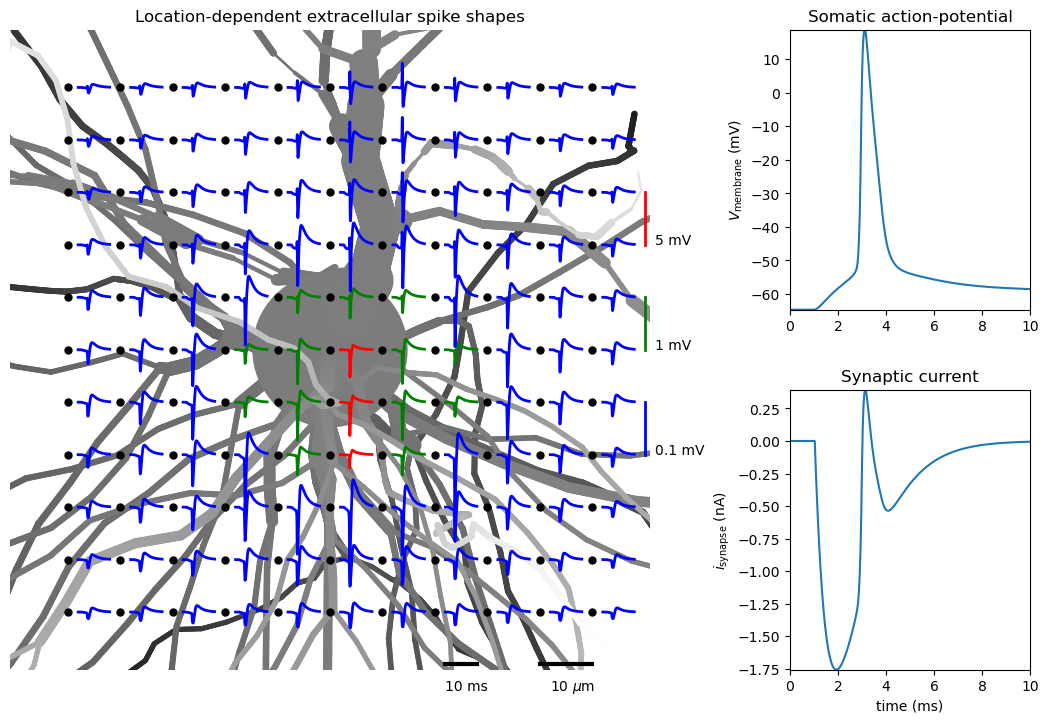

In [8]:
from example_suppl import plot_ex2
fig = plot_ex2(cell, electrode)

In [9]:
from example_suppl import plotstuff
#fig = plotstuff(cell, electrode)
# TODO need to customize the plotstuff function to work with this example